<a href="https://colab.research.google.com/github/google/applied-machine-learning-intensive/blob/master/content/04_classification/06_images_and_video/00-pil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Manipulating an Image in Python

So far in this course, the data that we have encountered has been in some text format, such as comma separated values of strings and numbers. Other data has been directly loaded from scikit-learn as a `Bunch` of NumPy arrays, also containing strings and numbers.

Data scientists sometimes find themselves working with collections of images, which are represented in a much more compact binary format. One of the most common examples of working with images is image classification, e.g., reverse image search.

These images are often contained in a zip file, but they can also be in a directory on your computer or even on the internet. Once you have the images, you'll typically need to perform some type of preprocessing on them before you can do any sort of modeling.

Most models expect a specific size of image, so you'll need to resize the images you feed your model if they differ from what is expected. Resizing might include cropping, stretching, padding, and scaling an image. Resizing to a smaller size also helps speed up your model by reducing the size of the input data.

Images can also be encoded in many different ways. Some are grayscale; others are color. Color images might be encoded red-green-blue (RGB), blue-green-red (BGR), rgb-alpha, bgr-alpha, hue-saturation-lightness (HSL), hue-saturation-value (HSV), or some other encoding scheme. You will need to make sure your input images' encoding for all of your training data is the same.

It is also common to normalize or standardize your images, which are just two different ways of reducing a wide range of pixel values (typically `0 `to `255` inclusive) into a tighter range.

This might all sound like a lot of work, and it is. Fortunately, though, you don't have to worry too much about the details. There are numerous Python toolkits for manipulating images. In this unit, we will use the [Image](https://pillow.readthedocs.io/en/stable/reference/Image.html) and [ImageOps](https://pillow.readthedocs.io/en/stable/reference/ImageOps.html) modules from the [PIL (now called Pillow)](https://python-pillow.org/) library.

## Get Image

The image that we will work with comes from [Pixabay](https://pixabay.com/photos/running-shoe-shoe-brooks-371624/). On the image page, you'll see the option to download it. Choose the 1920x1280 version of the image.

After you have download the image to your computer, upload it into this Colab by running the code block below, clicking "Choose Files" in the form that appears, selecting the image that was just downloaded from the dialog box, and then pressing "Open". You should see messages about the file being uploaded and then eventually you'll see a notification that the file upload is complete.

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google.colab'

We can now take a look at our image to see if we uploaded it properly. To do this we will use [Matplotlib](https://matplotlib.org/) to display the image. But first we must load the image from the virtual machine hosting this Colab. Right now that image is stored on the virtual machine's hard drive.

We'll use Pillow's `Image` module to open the file.

Notice we use a [context block](https://docs.python.org/2.5/whatsnew/pep-343.html) to automatically close the image we opened in order to free up resources. We could also have just explicitly called close after we were done with the image.

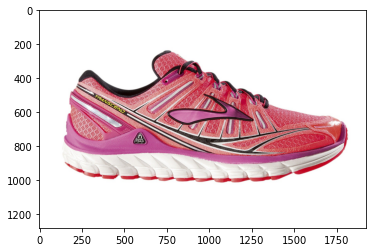

In [33]:
from PIL import Image
import matplotlib.pyplot as plt

image_file = "running-shoe-371624_1920.jpg"

with Image.open(image_file) as sneaker:
  plt.imshow(sneaker)
  plt.show()

## Reshaping

The image we currently have is wider than it is tall (landscape). It could have just as easily been taller than it is wide (portrait). It could have even been a square.

Does the model care? In some ways it does, and in others it doesn't. The model needs consistent inputs. These could be of any shape and size, but they must be consistent throughout the modeling.

First, we should know the size of the image we are working with. We can get that from Pillow by simply asking for the image size.

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

image_width_height = None

with Image.open(image_file) as sneaker:
  image_width_height = sneaker.size

print(image_width_height)

(1920, 1280)


As expected, we have dimensions that indicate that we have an image in landscape: 1920 pixels wide and 1280 pixels tall.

Now we have to figure out *if* and *how* to reshape it.

For the question of *if*, let's assume that we expect a variable set of input shapes, and based on this, we believe that reshaping is necessary.

Now we need to think about *how* to reshape the image. *How* can take many different formats:

* Do we find the smaller dimension and just add blank padding to it until it is the same size as the larger dimension?
 * If so, do we pad one side? Both?
 * And what pixel value(s) do we use for the padding? Min? Max? Average? Other?
* Do we crop a fixed portion of the image?
 * If so, do we center? Randomly crop? Multiple times?
* Do we simply resize the image and let it be proportionally distorted?

The answer to all of these questions completely depends on your problem domain and use case. This is actually part of the **science** of data science. Hypothesize, experiment, repeat.

But for this Colab, we have to make a definitive decision. For simplicity, we will choose to evenly pad the smaller dimension with white pixels as evenly as possible on either side.

To do this we first need to find the larger side (height or width) of the image.

In [3]:
max_dimension = max(image_width_height)

print(max_dimension)

1920


Now we need to find out how much padding we need to add to each side of the image. The longer side shouldn't get any extra padding, and since we want to make the image a square, the shorter side should get enough padding to make it equal to the longer side.

In this case we have a landscape picture. Therefore, no extra width is needed, and 640 pixels of height is needed.

In [4]:
width_padding = max_dimension - image_width_height[0]
height_padding = max_dimension - image_width_height[1]

print("Width padding: {}, Height padding: {}".format(width_padding, height_padding))

Width padding: 0, Height padding: 640


We don't want all of the padding to be on one side of the image, though. We need to split the amount of padding in half and then add each half of the padding to each side of the shorter dimension.

There is a problem when the padding is an odd number of pixels. A half of a pixel doesn't make sense, so instead we just need to choose a side of the image to put the extra bit of padding onto. In order to do this, we first do integer division to split the padding in half and then use subtraction to find the size of the other portion of the padding.

In [5]:
left_padding = width_padding // 2
right_padding = width_padding - left_padding

top_padding = height_padding // 2
bottom_padding = height_padding - top_padding

print("Left padding: {}, Top padding {}, Right padding: {}, Bottom padding {}".format(
  left_padding, 
  top_padding, 
  right_padding, 
  bottom_padding))

Left padding: 0, Top padding 320, Right padding: 0, Bottom padding 320


Now that we know how much padding to add to the image, we can do so by asking Pillow to expand the image.

We asked for the padding to be white (RGBA all `255`). This made sense in this case because this particular image contains one "object" and a solid white background. If your images are not so well-produced, you might need to use a different strategy for coloring the image padding.

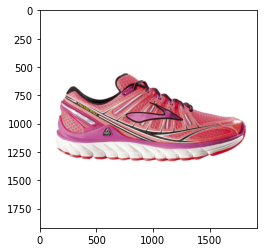

In [6]:
from PIL import ImageOps

padding = (
  left_padding, 
  top_padding, 
  right_padding, 
  bottom_padding
)

image = Image.open("running-shoe-371624_1920.jpg")
padded_image = ImageOps.expand(image, padding, (255,255,255,255))
image.close()

_ = plt.imshow(padded_image)

We will do one final check to confirm that the image is indeed a square now. You should now have a `1920x1920` image.

In [ ]:
padded_image.size

## Scale the Image

`1920x1920` is a pretty big image for a machine learning model to handle. If each pixel were used as input, that would be `3,686,400` values in the input vector for a model. It is common for each pixel to have three or four channels for a color image: red, green, blue, alpha. If there are four channels, the actual number of inputs is actually `14,745,600` for this image.

A common strategy to reduce the size of the inputs is to scale it down. Let's use Pillow to do that.

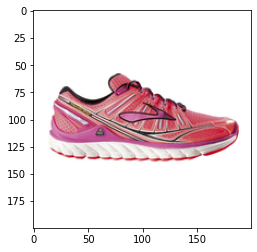

In [7]:
desired_size = (200, 200)

resized_image = padded_image.resize(desired_size, Image.ANTIALIAS)
_ = plt.imshow(resized_image)

We can see the exact size of the resized image.

In [8]:
resized_image.size

(200, 200)

Padding before resizing ensures that we don't distort the shape of the contents of our image, but it did require that we apply an artificial background.

We could have also just scaled the image into a `200x200` square and distorted the image.

Which is better really depends on what type of image you have coming into your system and the problem you are trying to solve.

# Exercises

## Exercise 1

Your turn!  Find another sneaker image and make it square and a size of 100 by 100 pixels.  Use your favorite image search website if you don't have a sneaker image handy, e.g.: [Pixabay](https://pixabay.com), [Google Image Search](https://images.google.com), etc.

### **Student Solution**

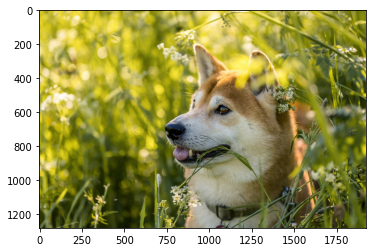

(1920, 1280)
1920
Width padding: 0, Height padding: 640
Left padding: 0, Top padding 320, Right padding: 0, Bottom padding 320


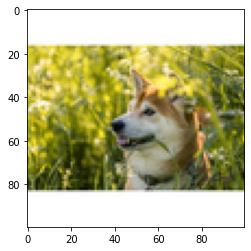

In [19]:
### YOUR CODE HERE ###

# Open the image file and plot the image
image_file = "shiba-6292660_1920.jpg"

with Image.open(image_file) as dog:
  plt.imshow(sneaker)
  plt.show()



# Print the dimension of the image
print(dog.size)


# Find the longer dimension  
max_dimension = max(dog.size)

print(max_dimension)


# Compute the delta width and height
width_padding = max_dimension - image_width_height[0]
height_padding = max_dimension - image_width_height[1]

print("Width padding: {}, Height padding: {}".format(width_padding, height_padding))

# Compute the padding amounts
left_padding = width_padding // 2
right_padding = width_padding - left_padding

top_padding = height_padding // 2
bottom_padding = height_padding - top_padding

print("Left padding: {}, Top padding {}, Right padding: {}, Bottom padding {}".format(
  left_padding, 
  top_padding, 
  right_padding, 
  bottom_padding))

# Pad and plot the image

padding = (
  left_padding, 
  top_padding, 
  right_padding, 
  bottom_padding
)

image = Image.open("shiba-6292660_1920.jpg")
padded_image = ImageOps.expand(image, padding, (255,255,255,255))


_ = plt.imshow(padded_image)

# Resize and plot the image
desired_size = (100, 100)

resized_image = padded_image.resize(desired_size, Image.ANTIALIAS)
_ = plt.imshow(resized_image)

plt.show()

---

## Exercise 2

Pick one of the images above, and do the following:

1.   Flip the image horizontally (left to right).
2.   Then, save the flipped image back to overwrite the original image file.

Resource: [PIL Reference Guide](https://pillow.readthedocs.io/en/3.0.x/reference/ImageOps.html)



### **Student Solution**

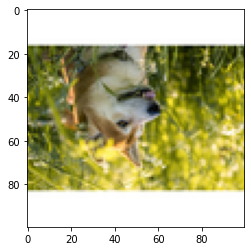

In [31]:
### YOUR CODE HERE ###


dog_image = resized_image.rotate(180,expand = 1)
# Flip the image horizontally (left to right)

# Plot the image to show the image is indeed flipped horizontally

plt.imshow(dog_image)

In [ ]:
### YOUR CODE HERE ###

# Save newly generated image to the folder




---